In [131]:
import sys
import os
from matplotlib import pyplot as plt
import numpy as np
# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
# Now you can import the TimeSeriesDataset class
from TimeSeriesDataset import TimeSeriesDataset as TSD
from utils import download_data

In [132]:
dataset_PT = TSD(file_path='../datasets/power_transitions.xlsx')

Dataset loaded from ../datasets/power_transitions.xlsx


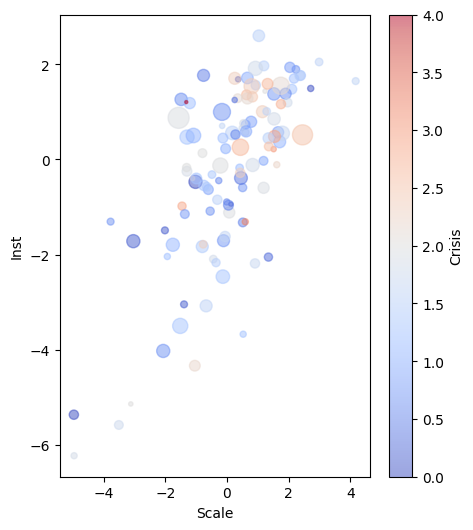

In [136]:
import matplotlib.pyplot as plt

polity_group = dataset_PT.scv_imputed.groupby('PolityName')
fig, ax = plt.subplots(figsize=(5, 6))
# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Inst_1'].mean()
mean_scale_1 = polity_group['Scale_1'].mean()
mean_crisis = polity_group['Crisis'].mean()
num_observations = polity_group.size()

# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 5,
                      alpha=0.5,
                      edgecolors=plt.cm.coolwarm(mean_crisis / mean_crisis.max())
                      )

# Add a color bar
plt.colorbar(scatter, label='Crisis')

# Show the plot
plt.ylabel('Inst')
plt.xlabel('Scale')
plt.show()

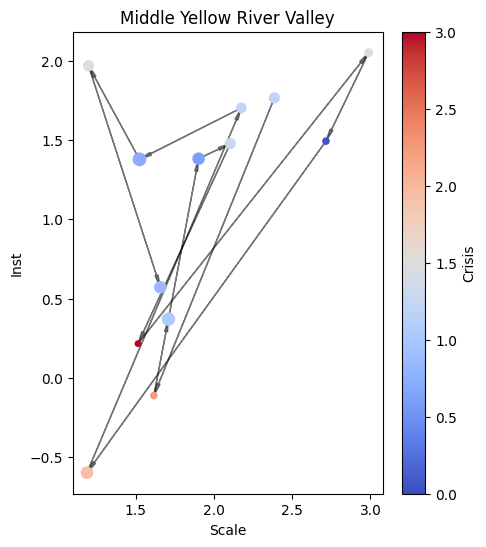

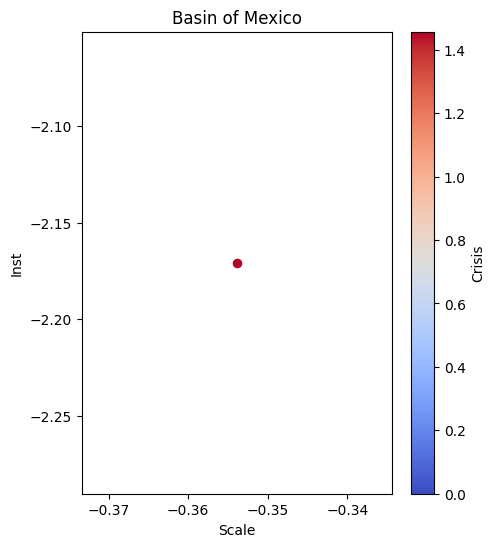

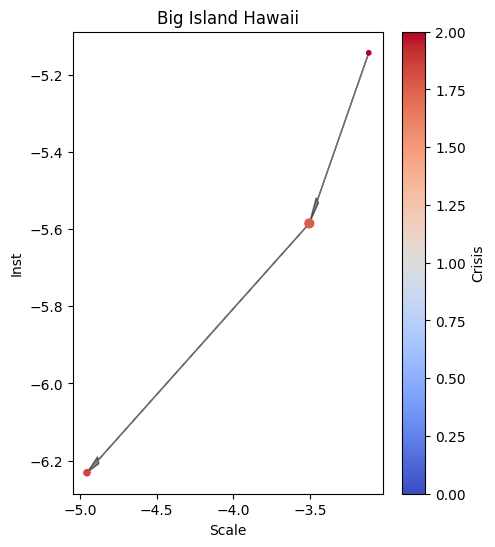

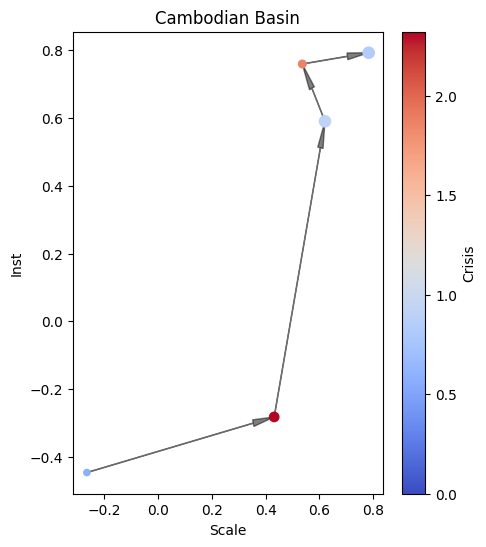

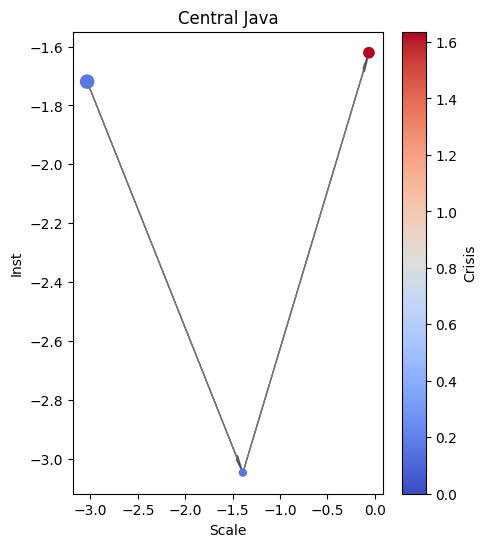

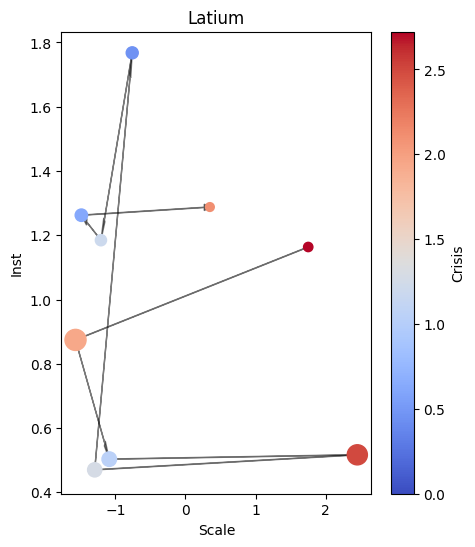

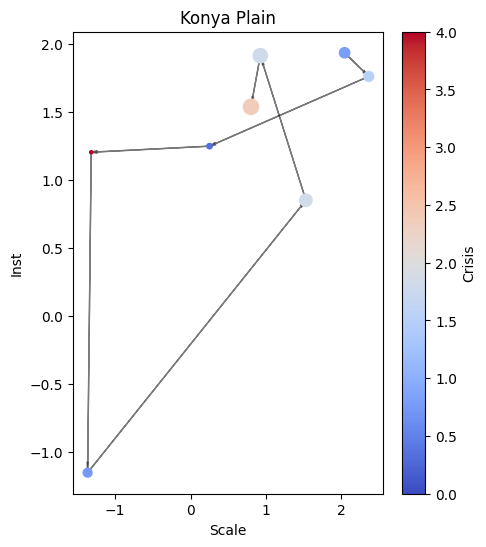

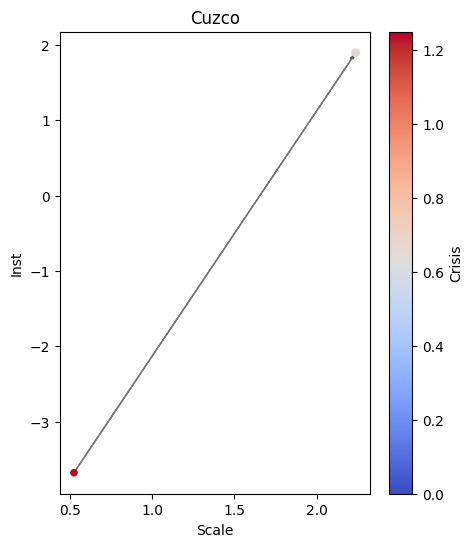

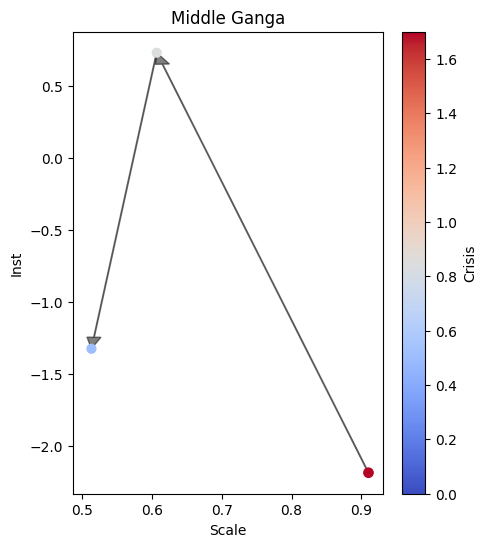

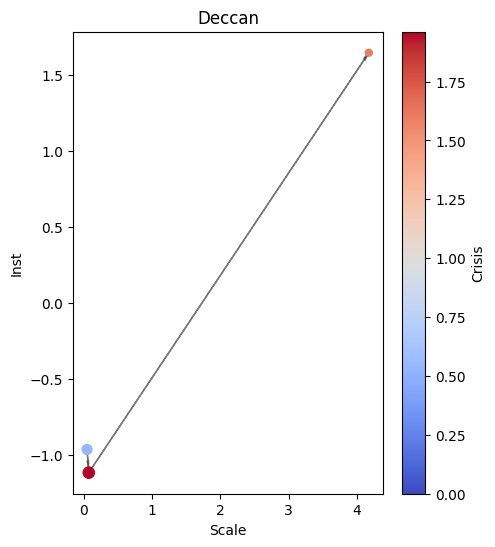

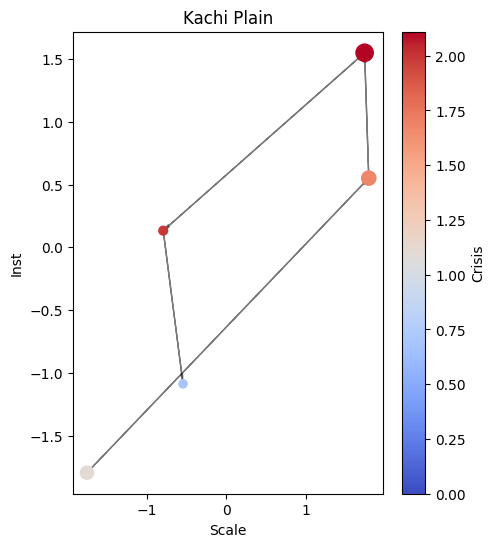

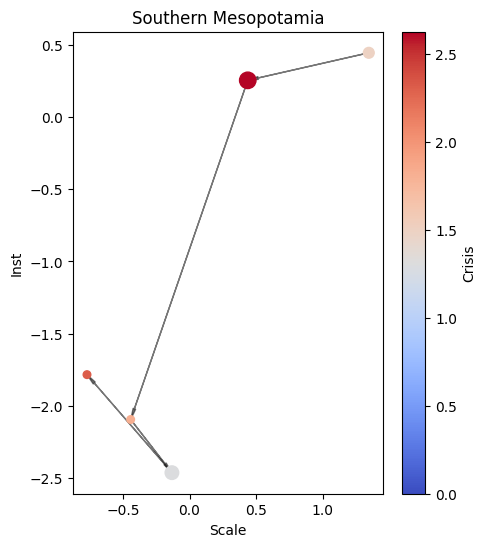

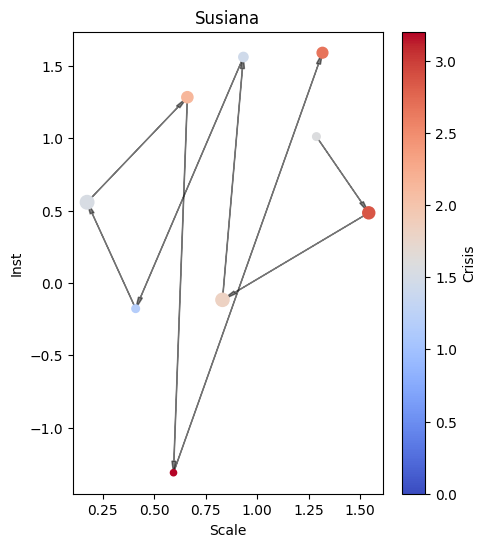

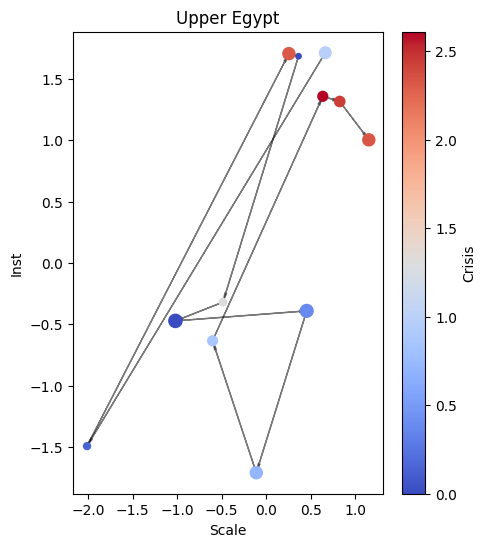

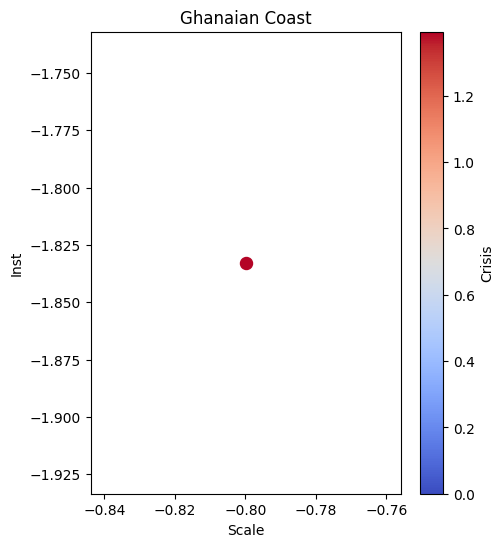

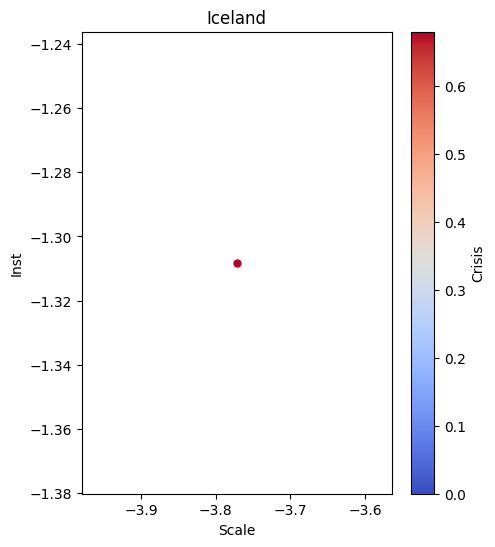

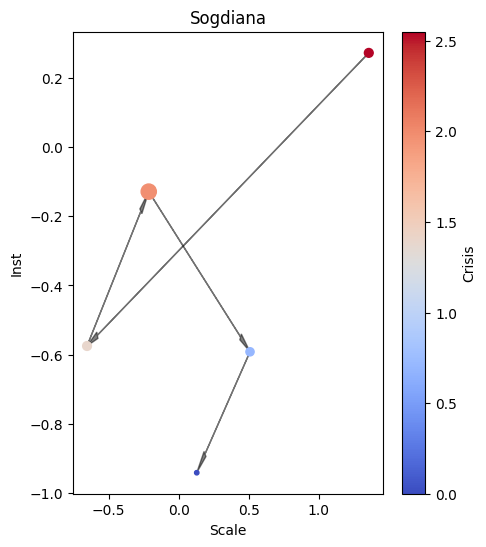

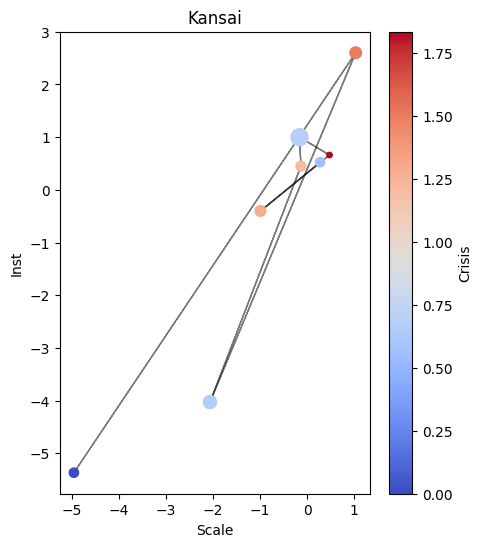

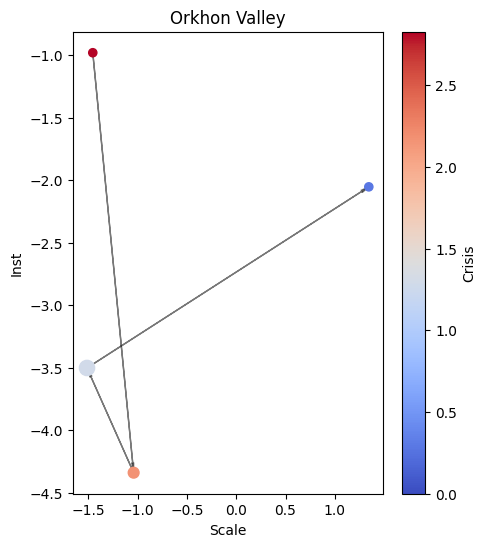

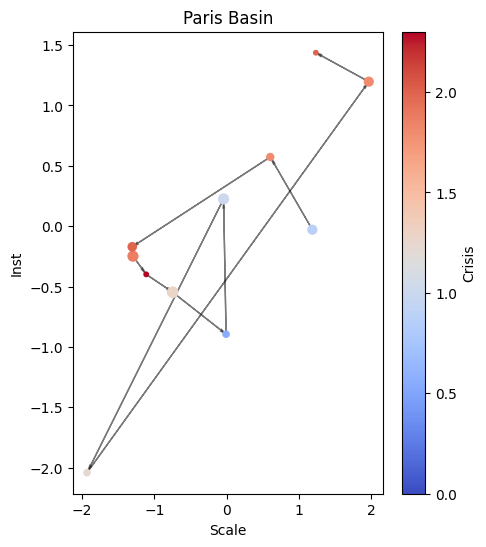

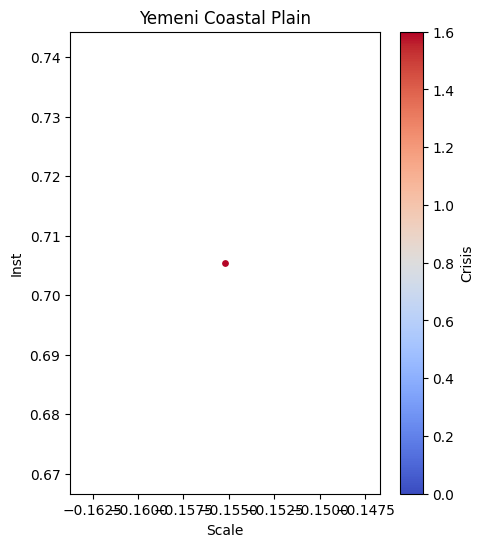

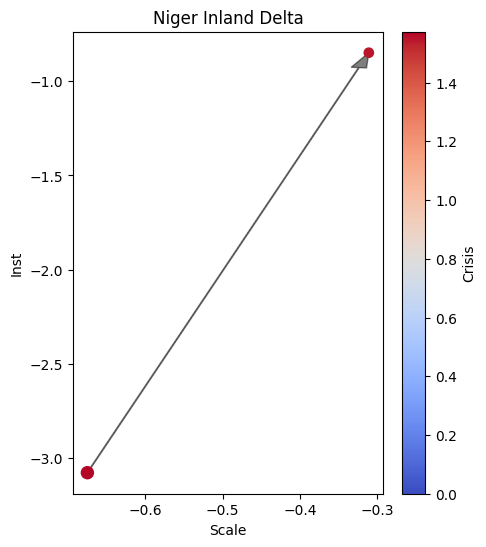

In [165]:
NGAs = dataset_PT.scv_imputed['NGA'].unique()

for nga in NGAs:
    polity_group = dataset_PT.scv_imputed.loc[dataset_PT.scv_imputed.NGA == nga].groupby('PolityName')
    fig, ax = plt.subplots(figsize=(5, 6))
    # Assuming polity_group is a DataFrame or GroupBy object
    mean_inst_1 = polity_group['Inst_1'].mean()
    mean_scale_1 = polity_group['Scale_1'].mean()
    mean_crisis = polity_group['Crisis'].mean()
    num_observations = polity_group.size()
    
    for i in range(1,len(mean_inst_1)):
        dx = (mean_scale_1[i-1] - mean_scale_1[i]) 
        dy = (mean_inst_1[i-1] - mean_inst_1[i]) 
        plt.arrow(mean_scale_1[i], mean_inst_1[i],dx,dy, head_width=0.02, head_length=0.08, fc='k', ec='k', length_includes_head = True, alpha = 0.5)

    # Create a scatter plot
    scatter = plt.scatter(mean_scale_1, mean_inst_1,
                        vmin = 0,
                        c=mean_crisis,
                        cmap='coolwarm',
                        s=num_observations * 5,
                        alpha=1.0,
                        edgecolors=plt.cm.coolwarm(mean_crisis / mean_crisis.max())
                        )

    # Add a color bar
    plt.colorbar(scatter, label='Crisis')


    # Show the plot
    plt.ylabel('Inst')
    plt.xlabel('Scale')
    plt.title(nga)
    plt.show()

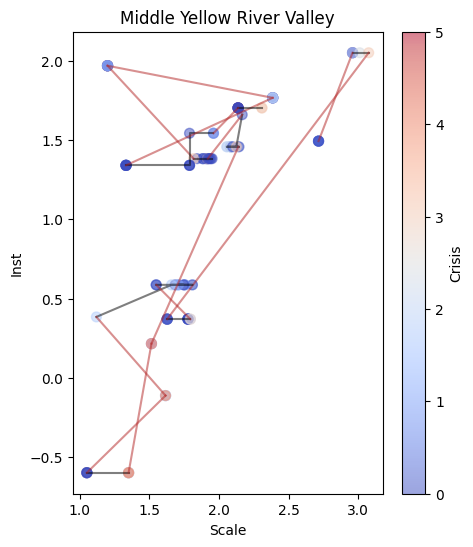

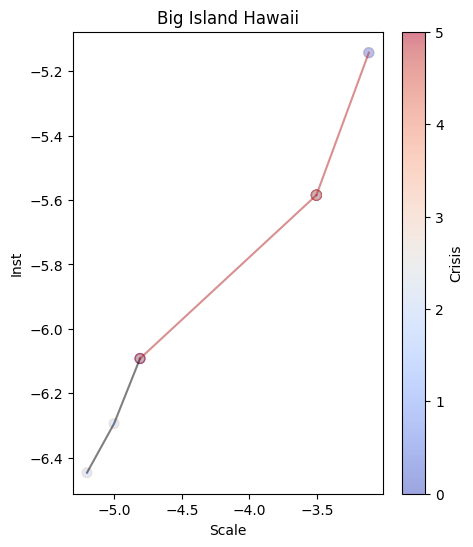

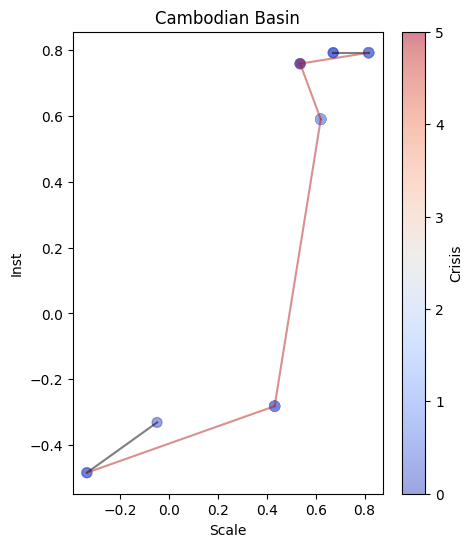

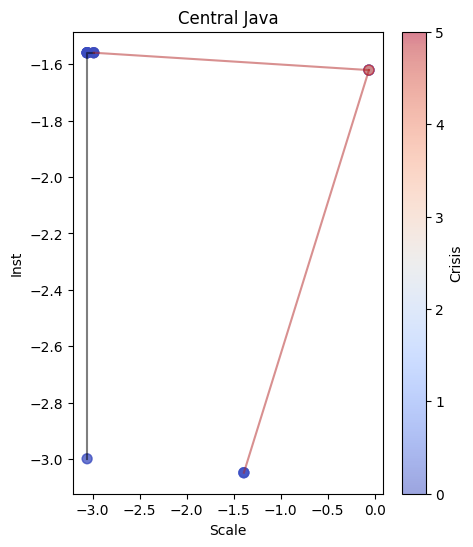

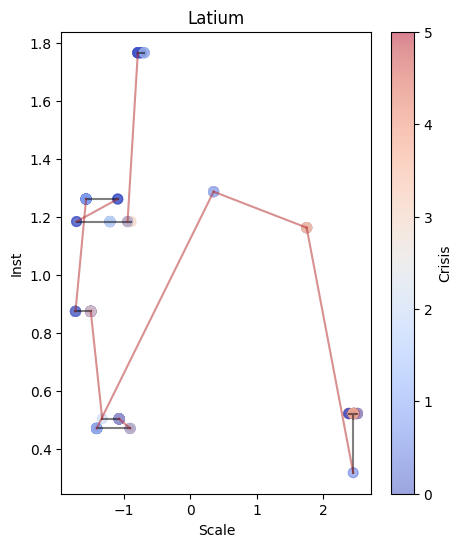

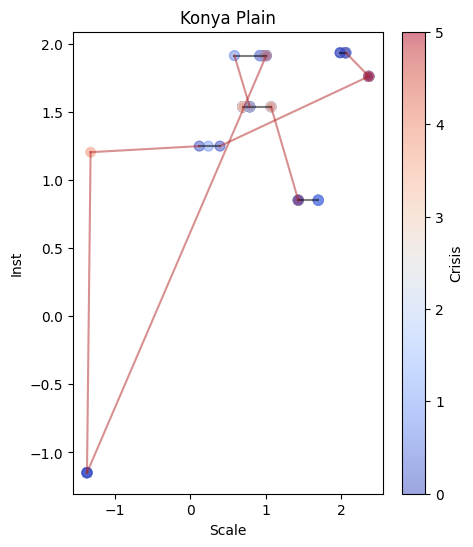

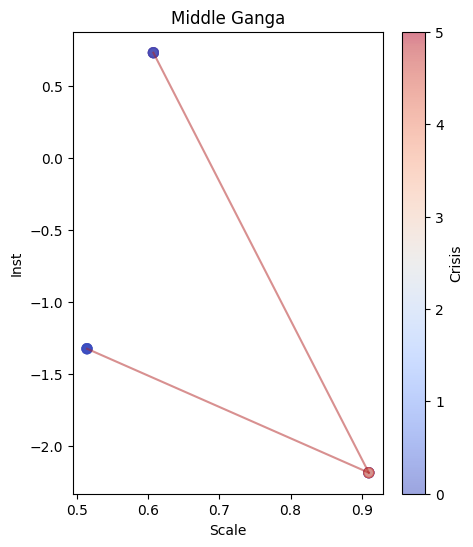

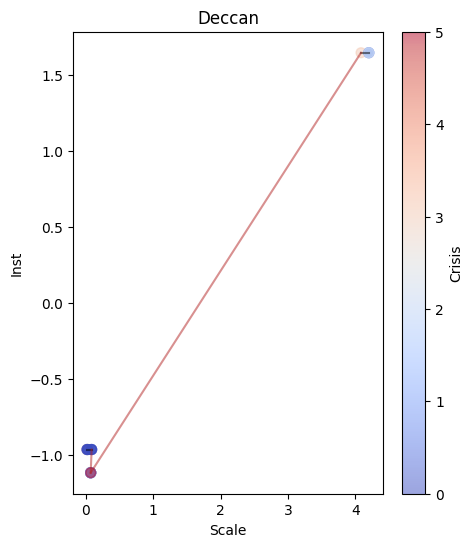

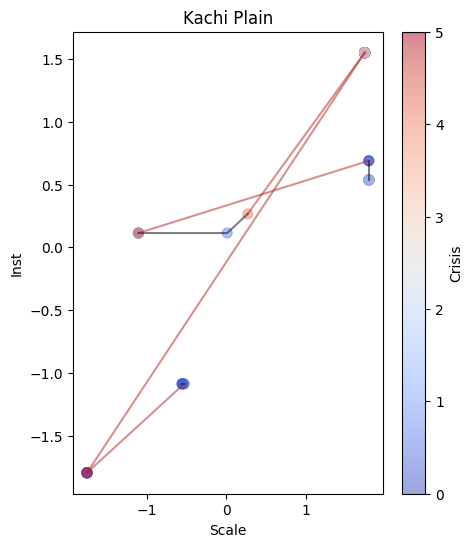

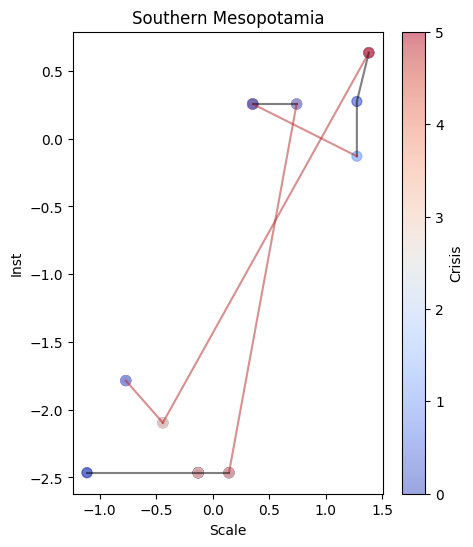

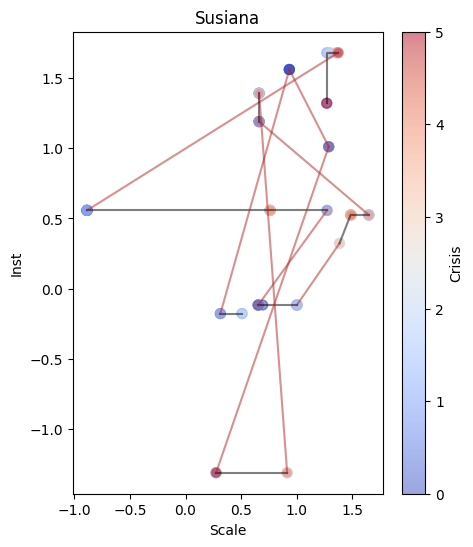

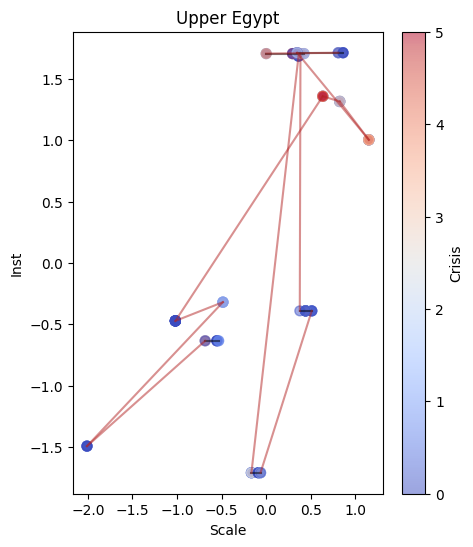

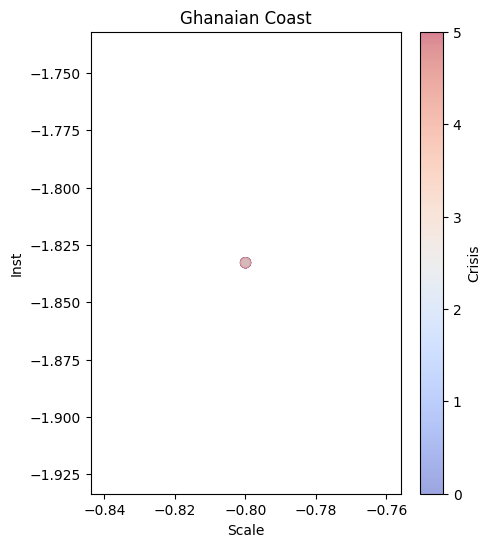

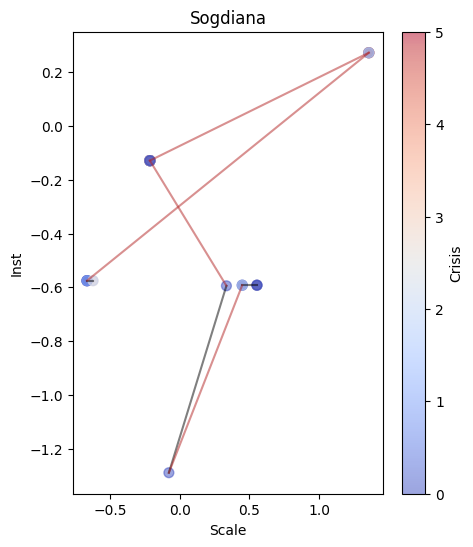

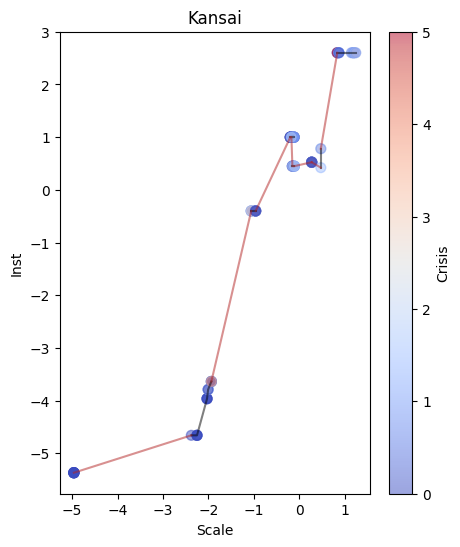

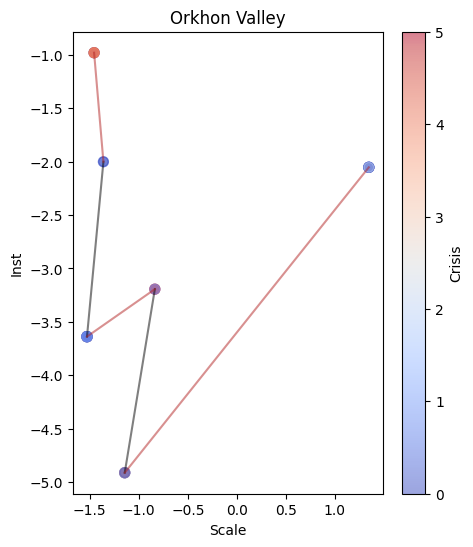

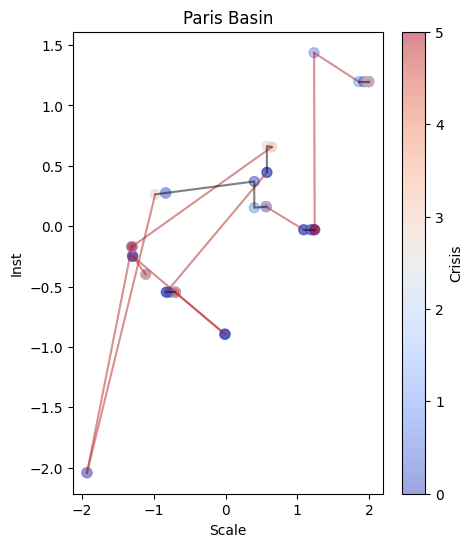

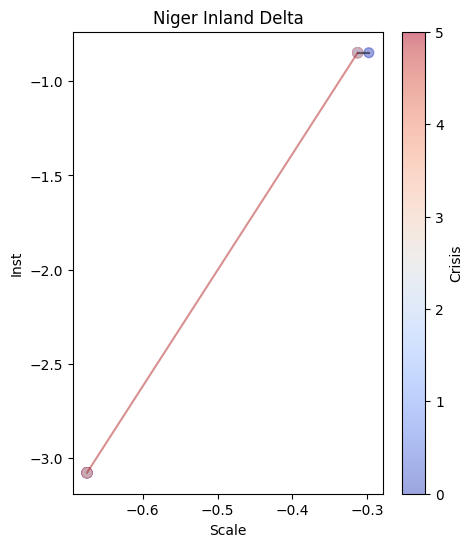

In [ ]:
NGAs = dataset_PT.scv_imputed['NGA'].unique()

for nga in NGAs:

    plot_df = dataset_PT.scv_imputed[dataset_PT.scv_imputed['NGA'] == nga]
    if len(plot_df) > 10:                
        fig, ax = plt.subplots(figsize=(5, 6))

        # Create a scatter plot
        scatter = plt.scatter(plot_df['Scale_1'], plot_df['Inst_1'],
                            vmin=0,
                            vmax = 5,
                            c=plot_df['Crisis'],
                            cmap='coolwarm',
                            s=50,
                            alpha=0.5,
                            edgecolors=plt.cm.coolwarm(plot_df['Crisis'] / plot_df['Crisis'].max())
                            )
        for i,pol in enumerate(plot_df['PolityName'].unique()):
            pol_df = plot_df[plot_df['PolityName'] == pol]
            plt.plot(pol_df['Scale_1'], pol_df['Inst_1'], 'k', alpha=0.5)
            if i > 0:
                prev_pol = plot_df[plot_df['PolityName'] == plot_df['PolityName'].unique()[i-1]]
                plt.plot([prev_pol['Scale_1'].iloc[-1], pol_df['Scale_1'].iloc[0]], [prev_pol['Inst_1'].iloc[-1], pol_df['Inst_1'].iloc[0]], 'firebrick', alpha=0.5)
            
        
        # Add a color bar
        plt.colorbar(scatter, label='Crisis')         
        # Show the plot
        plt.title(nga)
        plt.ylabel('Inst')
        plt.xlabel('Scale')
        plt.show()  
    
